# Image-to-Point Model Training

This notebook takes the work done in the Inital Exploration notebook and trains a convolutional neural network (CNN) to generate a wheel angle in real dimensional space. The network architecture will follow the [DAVE-2](https://developer.nvidia.com/blog/deep-learning-self-driving-cars/) as previously done by NVIDIA and train using the [DeepPicar-v2](https://github.com/mbechtel2/DeepPicar-v2) dataset and the same model car. The first thing to do is to build the CNN.

## Model Building

Since this project is not being made into an overall package, what will be done is simply copy the relavent cells from the initial exploration to build the CNN in Tensorflow V2.

In [1]:
from cv2 import cv2              # an open computer vision module
import glob                      # Regix searching of files
import imageio                   # loading images in numpy array
import matplotlib.pyplot as plt  # Plotting
%matplotlib notebook
import numpy as np               # Array/Tensors
import os                        # finding paths
import pandas as pd              # Dataframe for viewing
import random                    # For shuffling a video list
import sys                       # manipulating the path variable
import tensorflow as tf          # Neural Networks

In [2]:
# Image input specifications
input_img_height = 66
input_img_width = 200
input_img_channels = 3


def create_dave(input_shape):
    # Create tensorflow object
    dave_2_model = tf.keras.Sequential()

    # First is a normalization layer in DAVE-2 but I don't see it in DeepPicar-v2 model-5conv_3fc
    # Attempting to normalize over color
    dave_2_model.add(tf.keras.layers.LayerNormalization(
        axis=[1, 2, 3], trainable=False,
        input_shape=input_shape  # Specify ahead of time for compilation
    ))

    # Second portion is the sequential 5x5 convolutions of increasing filters at 2x2 strides
    for i in range(3):
        dave_2_model.add(tf.keras.layers.Conv2D(
            filters=(24 + i*12),
            kernel_size=(5,5),
            strides=(2,2),
            padding='valid',
            data_format='channels_last',
            activation=tf.nn.relu
        ))

    # Third there is another grouping of Conv2D layers but a 3x3 kernel with no stride
    for i in range(2):
        dave_2_model.add(tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3,3),
            padding='valid',
            data_format='channels_last',
            activation=tf.nn.relu
        ))

    # Fourth and final part is a flattening and then reduction to a single output
    dave_2_model.add(tf.keras.layers.Flatten())
    for n_neurons in [100, 50, 10, 1]:
        dave_2_model.add(tf.keras.layers.Dense(
            units=n_neurons,
            activation=(tf.nn.tanh if n_neurons == 1 else tf.nn.relu)
        ))

    # Compiling the model to see the initial structure
    dave_2_model.compile(
        optimizer='adam',
        loss=['mse'],
        metrics=['mse']
    )
    
    return dave_2_model

dave_2_model = create_dave((input_img_height, input_img_width, input_img_channels))
dave_2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 66, 200, 3)        79200     
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

## Model Training

The original dataset had only discrete anlges for steering, namely the steering angle $\theta \in\lbrace -30,\ 0,\ 30 \rbrace$ but we wish for a continuous controller so a central moving average will be applied to the edge padding. The total dataset spans 11 videos of 11,000 frames but 1,000 frames is already pushing my laptop memory limits. The current plan to tackle this issue is to queue a video to go through, get the estimated continuous controls, and then batch train a video. As for wether to loop through all videos before any potential repeats or simply randomly train, it isn't clear a priori which is better. For now simply iterating it easiest to at least get a simple model. Setting the training:

In [3]:
# Grab video file list
dpv2_video_files = glob.glob("../data/external/DeepPicar-v2-data/*.avi")
# random.shuffle(dpv2_video_files)  # Shuffle to randomize for train-test split
"""
For recreatability, the model was trained on these in order:

../data/external/DeepPicar-v2-data\out-video-2.avi
../data/external/DeepPicar-v2-data\out-video-9.avi
../data/external/DeepPicar-v2-data\out-video-7.avi
../data/external/DeepPicar-v2-data\out-video-8.avi
../data/external/DeepPicar-v2-data\out-video-10.avi
../data/external/DeepPicar-v2-data\out-video-1.avi
../data/external/DeepPicar-v2-data\out-video-11.avi
../data/external/DeepPicar-v2-data\out-video-6.avi
../data/external/DeepPicar-v2-data\out-video-4.avi

And tested on these in order
../data/external/DeepPicar-v2-data\\out-video-3.avi
../data/external/DeepPicar-v2-data\\out-video-5.avi
"""
temp = []# For recreatability []
for i in [1, 8, 6, 7, 9, 0, 10, 5, 3, 2, 4]:
    temp = temp + [dpv2_video_files[i],]
dpv2_video_files = temp

# Some constants for analyzing videos from DeepPicar-v2
N_FRAMES = 1000  # All avi files in DeepPicar-v2 are 1,000 frames
ORIG_IMG_HEIGHT = 240
ORIG_IMG_WIDTH = 320
N_VIDEOS = len(dpv2_video_files)


# Define some helper functions
def key_from_video_filename(vf : str):
    directory_seperated = vf.split('\\')  # running on Windows
    fileno = int(directory_seperated[-1].split('-')[-1].split('.')[0])
    key_filename = 'out-key-%i.csv' % fileno
    return '\\'.join(directory_seperated[:-1] + [key_filename,])

In [4]:
# Filter setup
f_size = 5
f_array = np.ones((f_size,))/f_size
n_pad = int(np.ceil(f_size/2))

# Training Constants
EPOCHS = 50
VAL_SPLIT = 0.2
BATCH_SIZE = 256  # Want it to be a power of 4
N_IMAGES_PER_TRAINING_SEGMENT = 200
N_TRAIN_VIDEOS = 9  # 9/11  for train-val and 2/11 for testing
N_IMAGE_AUGS = 2  # Just flipping for now
N_LOOPS_THROUGH_VIDEOS = 4  # Looks like 4-5 is sufficient

# Output scaling
y_sf = np.pi/6  # 30 degrees

In [5]:
# Sperate to avoid changing a parameter and then restarting from scratch
training_history = None

In [6]:
# Rerunning this cell will append to training.
# Additional epochs: EPOCHS*(N_FRAMES/N_IMAGES_PER_TRAINING_SEGMENT)*N_TRAIN_VIDEOS*N_LOOPS_THROUGH_VIDEOS

assert N_FRAMES % N_IMAGES_PER_TRAINING_SEGMENT == 0, "Need even division of video frames over training"
# Loop over videos
for i in range(N_LOOPS_THROUGH_VIDEOS):
    print(f"Loop {i}:")
    # Iterate through the videos for training
    for vf in dpv2_video_files[:N_TRAIN_VIDEOS]:
        print(f"\t{vf}")
        
        # Load in csv of correct outputs
        y_video = np.loadtxt(
            fname=key_from_video_filename(vf),
            delimiter=',',
            skiprows=1,  # ignore the column titles
            usecols=2  # Angle is in the third column
        )/y_sf

        # Pad, filter, and then reduce
        temp = np.pad(y_video, pad_width=n_pad, mode='edge')
        del y_video
        y_video = np.convolve(temp, f_array, mode='same')[n_pad:-n_pad]
        del temp

        # Allocate training tensors
        x_train = np.empty((N_IMAGE_AUGS*N_IMAGES_PER_TRAINING_SEGMENT, input_img_height, input_img_width, 3))
        y_train = np.empty((N_IMAGE_AUGS*N_IMAGES_PER_TRAINING_SEGMENT,))

        # Preallocate load tensor
        x_load = np.empty((N_IMAGES_PER_TRAINING_SEGMENT, ORIG_IMG_HEIGHT, ORIG_IMG_WIDTH, 3))

        # Get video capture going
        video_capture = cv2.VideoCapture(vf)

        # Iterate through video training batches
        for j in range(N_FRAMES // N_IMAGES_PER_TRAINING_SEGMENT):

            # Load in the N_IMAGES_PER_TRAINING_SEGMENT
            for k in range(N_IMAGES_PER_TRAINING_SEGMENT):
                _, image = video_capture.read()
                x_load[k] = image
                del image

            # Reshape from AVI to DAVE-2
            x_train[:N_IMAGES_PER_TRAINING_SEGMENT] = tf.image.resize(
                images=tf.convert_to_tensor(x_load),
                size=[input_img_height, input_img_width]
            ).numpy()

            # Get corresponding outputs
            y_train[:N_IMAGES_PER_TRAINING_SEGMENT] = y_video[
                j*N_IMAGES_PER_TRAINING_SEGMENT:(j+1)*N_IMAGES_PER_TRAINING_SEGMENT
            ]

            # Image Augmentation and output correspondance
            # Horizontal flip:
            x_train[N_IMAGES_PER_TRAINING_SEGMENT:] = x_train[:N_IMAGES_PER_TRAINING_SEGMENT,:,::-1,:]
            y_train[N_IMAGES_PER_TRAINING_SEGMENT:] = -y_train[:N_IMAGES_PER_TRAINING_SEGMENT]

            # Train the model
            session_hist = dave_2_model.fit(
                x=x_train, y=y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=0,  # 1,
                validation_split=VAL_SPLIT,
            )

            # Append in training history
            sess_hist = np.stack((
                    np.array(session_hist.history['loss']),
                    np.array(session_hist.history['val_loss'])
                ), axis=0).T

            if training_history is None:
                training_history = sess_hist
            else:
                temp = np.concatenate((training_history, sess_hist), axis=0)
                del training_history
                training_history = temp
                del temp
            del sess_hist

        # Some resource freeing
        video_capture.release()

        # Free up memory
        del x_train, y_train, x_load, y_video, video_capture
    

Loop 0:
	../data/external/DeepPicar-v2-data\out-video-2.avi
	../data/external/DeepPicar-v2-data\out-video-9.avi
	../data/external/DeepPicar-v2-data\out-video-7.avi
	../data/external/DeepPicar-v2-data\out-video-8.avi
	../data/external/DeepPicar-v2-data\out-video-10.avi
	../data/external/DeepPicar-v2-data\out-video-1.avi
	../data/external/DeepPicar-v2-data\out-video-11.avi
	../data/external/DeepPicar-v2-data\out-video-6.avi
	../data/external/DeepPicar-v2-data\out-video-4.avi
Loop 1:
	../data/external/DeepPicar-v2-data\out-video-2.avi
	../data/external/DeepPicar-v2-data\out-video-9.avi
	../data/external/DeepPicar-v2-data\out-video-7.avi
	../data/external/DeepPicar-v2-data\out-video-8.avi
	../data/external/DeepPicar-v2-data\out-video-10.avi
	../data/external/DeepPicar-v2-data\out-video-1.avi
	../data/external/DeepPicar-v2-data\out-video-11.avi
	../data/external/DeepPicar-v2-data\out-video-6.avi
	../data/external/DeepPicar-v2-data\out-video-4.avi
Loop 2:
	../data/external/DeepPicar-v2-data\

In [16]:
dave_2_model.save_weights(
    filepath="../models/temporary/cnn-image-to-point.h5"
)
np.save("../reports/training-history/temp/ccn-i2p-th.npy", training_history)

## Model Verification

This portion will check both the training history to demonstrate progress as well as find the accuracy of a classifier and MSE loss function on the test videos to show models validity.

### Training History

The overall training history of the model:

<IPython.core.display.Javascript object>


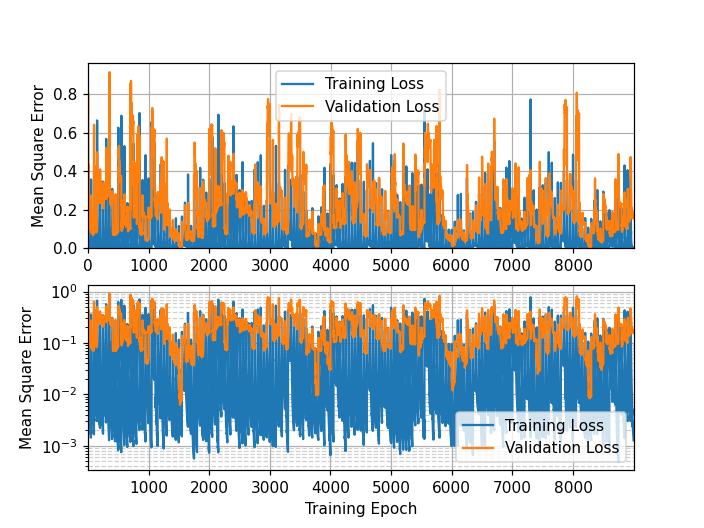

In [24]:
epoch_vec = np.arange(training_history.shape[0])

fig, ax = plt.subplots(2, 1)

ax[0].plot(epoch_vec, training_history[:, 0], color='C0', label="Training Loss")
ax[0].plot(epoch_vec, training_history[:, 1], color='C1', label="Validation Loss")

ax[0].set_xlim(left=0, right=epoch_vec[-1])
ax[0].set_ylim(bottom=0)

# ax[0].set_xlabel("Training Epoch")
ax[0].set_ylabel("Mean Square Error")

ax[0].legend()

ax[0].grid(True, which='major',  linestyle='-')
ax[0].grid(True, which='minor',  linestyle='--', alpha=0.6)

ax[1].plot(epoch_vec[1:], training_history[1:, 0], color='C0', label="Training Loss")
ax[1].plot(epoch_vec[1:], training_history[1:, 1], color='C1', label="Validation Loss")

ax[1].set_xlim(left=1, right=epoch_vec[-1])
ax[1].set_yscale('log')

ax[1].set_xlabel("Training Epoch")
ax[1].set_ylabel("Mean Square Error")

ax[1].legend()

ax[1].grid(True, which='major',  linestyle='-')
ax[1].grid(True, which='minor',  linestyle='--', alpha=0.6)

# Put in dashed and solid lines to indicate new data shifts


plt.show()

The above training history shows some improvement over time, roughly a half decade over the four loops albeit it is hard to tell. From previous versions of this notebook, there was a large divergence to where the model was only predicting straight lines after about 7 loops through 9 videos so another couple of loops might help the current model.

### Model accuracy

Going from continuous to discrete again, now trying to show the accuracy of the model if simply turning at 30$^\circ$ or going straight. This is to give a more direct comparison with DeepPicar-v2.

In [8]:
# Some preallocations
N_TEST_VIDEOS = N_VIDEOS - N_TRAIN_VIDEOS

y_pred = np.empty((N_FRAMES*N_TEST_VIDEOS,))
y_act = np.empty((N_FRAMES*N_TEST_VIDEOS,))

nan
nan


In [9]:
# Iterate through the videos
for i, vf in enumerate(dpv2_video_files[N_TRAIN_VIDEOS:]):
    # Read in actual steering angle
    y_act[i*N_FRAMES:(i+1)*N_FRAMES] = np.loadtxt(
            fname=key_from_video_filename(vf),
            delimiter=',',
            skiprows=1,  # ignore the column titles
            usecols=2  # Angle is in the third column
        )/y_sf
    
    # Preallocate load tensor
    image_tensor = np.empty((N_IMAGES_PER_TRAINING_SEGMENT, ORIG_IMG_HEIGHT, ORIG_IMG_WIDTH, 3))

    # Get video capture going
    video_capture = cv2.VideoCapture(vf)

    # Iterate through video by training batches since we know that works
    for j in range(N_FRAMES // N_IMAGES_PER_TRAINING_SEGMENT):

        # Load in the N_IMAGES_PER_TRAINING_SEGMENT
        for k in range(N_IMAGES_PER_TRAINING_SEGMENT):
            _, image = video_capture.read()
            image_tensor[k] = image
            del image
        
        # Preform prediction
        y_pred[
            (i*N_FRAMES + j*N_IMAGES_PER_TRAINING_SEGMENT):(i*N_FRAMES + (j+1)*N_IMAGES_PER_TRAINING_SEGMENT)
        ] = dave_2_model.predict(
            x=tf.image.resize(
                images=tf.convert_to_tensor(image_tensor),
                size=[input_img_height, input_img_width]
            ).numpy(),
            verbose=1
        )[:,0]  # Already in (-1, 1)
    
    # Some resource freeing
    video_capture.release()
    del image_tensor

200/200 [==============================] - 0s 355us/sample


In [10]:
# Do rounding to ensure -1, 0, 1
y_pred = np.round(y_pred).astype('int')
y_act = np.round(y_act).astype('int')

In [13]:
cross_correlation_matrix = np.zeros((3,3))  # correlation matrix to see matches
for i in range(3):
    for j in range(3):
        cross_correlation_matrix[i, j] = np.count_nonzero(np.logical_and(
            np.equal(y_act, i-1),
            np.equal(y_pred, j-1),
        ))
        
"""
Quick note:
* column is predicted angle from -30 to 30 in left to right.
* row is actual from -30 to 30 from top to bottom.
"""
print(cross_correlation_matrix)

# Printing out the model statistics of discrete controller in the augmented domain
n_total = y_pred.shape[0]
n_correct = np.trace(cross_correlation_matrix)
n_incorrect = n_total - n_correct
print("Model accuracy: %2.2f%%'" % (100*n_correct/n_total))

[[ 48.  31.  21.]
 [156. 156. 188.]
 [ 54. 136. 205.]]
Model accuracy: 20.45%'


A brief comment about the accuracy is that going straight will be correct ~50% of the time but while the accuracy is low, there seems to be a lot of boarder cases so we will check the quality by overlaying results on the videos.

In [17]:
# Video constants
video_save_location = "../reports/video-quality-checks/image-to-point/"
AVI_WIDTH = 360
AVI_HEIGHT = 240


# Plotting constants
xbase = 180
ybase = 220
r = 120
r_text = r + 10
font = cv2.FONT_HERSHEY_SIMPLEX

# Iterate through the DeepPicar-v2 to make a video for quality analysis
for i, vf in enumerate(dpv2_video_files): 
    
    # Load in csv of correct outputs
    angle_video = np.loadtxt(
        fname=key_from_video_filename(vf),
        delimiter=',',
        skiprows=1,  # ignore the column titles
        usecols=2  # Angle is in the third column
    )
    
    # Save file name and reader ready
    vf_name = vf.split('\\')[-1]
    writer = None
    
    # Set up reading video
    cap = cv2.VideoCapture(vf)
    current_frame = 0
    
    # Read all the video
    while cap.isOpened():
        if current_frame < N_FRAMES:
            # Read in a frame from the video
            ret, frame = cap.read()

            # A quit option
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            # Initialize writer if necessary
            if writer is None:
                fourcc = cv2.VideoWriter_fourcc(*'DIVX')
                output_path = video_save_location + vf_name
                writer = cv2.VideoWriter(
                    output_path,
                    fourcc,  # color code
                    30,  # FPS
                    (frame.shape[1], frame.shape[0]),  # Image Shape
                    True  # in color
                )
                
            # Have the model predict the value
            theta = dave_2_model.predict(
                x=tf.image.resize(
                    images=tf.convert_to_tensor(frame.reshape((1,  ORIG_IMG_HEIGHT, ORIG_IMG_WIDTH, 3))),
                    size=[input_img_height, input_img_width]
                ).numpy(),
                verbose=0
            )[0,0]*y_sf  # Go from (-1, 1) to (-pi/6, pi/6)
            
            dx = int(r*np.sin(theta))
            dy = int(-r*np.cos(theta))
            dx_t = int(r_text*np.sin(theta))
            dy_t = int(-r_text*np.cos(theta))
            
            # Plot prediction on the frame
            frame = cv2.line(
                frame,
                (xbase, ybase),
                (xbase + dx, ybase + dy),
                (255,)*3,
                5
            )
            frame = cv2.putText(
                frame,
                'P',
                (xbase + dx_t, ybase + dy_t),
                font,
                2,
                (255,)*3,
                cv2.LINE_AA
            )
            
            # Calculations for actual on frame
            theta = angle_video[current_frame]
            
            dx = int(r*np.sin(theta))
            dy = int(-r*np.cos(theta))
            dx_t = int(r_text*np.sin(theta))
            dy_t = int(-r_text*np.cos(theta))
            
            # Plot prediction on the frame
            frame = cv2.line(
                frame,
                (xbase, ybase),
                (xbase + dx, ybase + dy),
                (255,) + (0,)*2,
                5
            )
            frame = cv2.putText(
                frame,
                'A',
                (xbase + dx_t, ybase + dy_t),
                font,
                2,
                (255,) + (0,)*2,
                cv2.LINE_AA
            )

            # Write out and increment
            writer.write(frame)
            current_frame += 1  # Increment a counter

            # Delete frame
            del frame
            
        else:
            writer.release()
            cap.release()
            cv2.destroyAllWindows()
            break

The videos indicate a decent driver that at least frame-wise is generally close to the human albeit both the model and humans have error. Hence the model trained in this notebook will be used.